In [1]:
import os
import sys; print('Python %s on %s' % (sys.version, sys.platform))
sys.path.extend([os.path.abspath('..')])

Python 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0] on linux


In [2]:
from denoising.helpers import *
import matplotlib.pyplot as plt
from seaborn import heatmap
from scipy.stats import zscore
from nilearn.connectome import sym_matrix_to_vec
import numpy as np
import warnings
#warnings.filterwarnings("ignore", category=FutureWarning)

from sklearn.covariance import GraphicalLasso, GraphicalLassoCV

In [3]:
pr = np.load('/home/tm/projects/OpenCloseProject/lasso_outputs/ihb/close_lasso_sub-0.npy')

<Axes: >

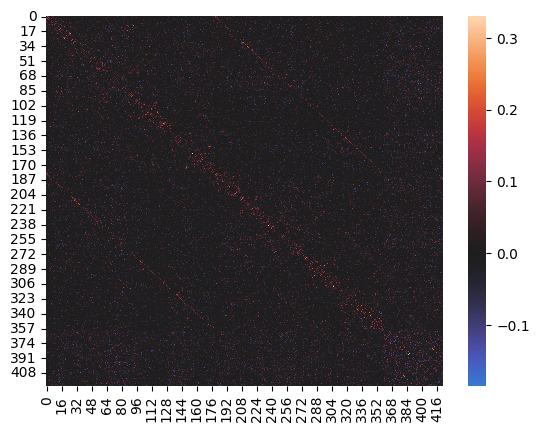

In [7]:
heatmap(pr, center=0)

In [3]:
def fetch_ts(path, sub=None, run=1, task='rest', strategy=4, atlas_name='AAL'):
    ts = []
    if sub is None:
        sub = os.listdir(path)
    failed = []
    for i in sub:
        if not isinstance(i, str):
            i = str(i)
        if 'sub' in i:
            i = i[4:]
        try:
            name = f'sub-{i}_task-{task}_run-{run}_time-series_{atlas_name}_strategy-{strategy}.csv'
            path_to_file = os.path.join(path, f'sub-{i}', 'time-series', atlas_name, name)
            #print(path_to_file)
            ts.append(pd.read_csv(path_to_file).values)
        except FileNotFoundError:
            failed.append(i)
            continue
    print('no files available:', failed)
    return ts

In [4]:
atlas = 'HCPex' # Schaefer200 AAL Brainnetome
strategy = 6

### load china data

In [5]:
import pandas as pd
# information about sessions
df = pd.read_csv('/arch/OpenCloseBeijin/BeijingEOEC.csv')
df.head()

,SubjectID,Age,Sex,Session_1,Session_2,Session_3
0,1725227,23,F,closed,open,closed
1,1925025,18,M,closed,closed,open
2,3235222,23,F,closed,open,closed
3,3457797,22,M,closed,closed,open
4,4207406,23,M,closed,open,closed


In [6]:
open_ids2 = df['SubjectID'].loc[df['Session_2'] == 'open'].values
open_ids3 = df['SubjectID'].loc[df['Session_3'] == 'open'].values

In [7]:
closed_ids2 = df['SubjectID'].loc[df['Session_2'] == 'closed'].values
closed_ids3 = df['SubjectID'].loc[df['Session_3'] == 'closed'].values

In [8]:
closed1 = fetch_ts('/data/Projects/OpenCloseChina/outputs_china',
                  # because first session is closed for everyone
                  run=1, atlas_name=atlas, strategy=strategy)

closed2 = fetch_ts('/data/Projects/OpenCloseChina/outputs_china',
                  sub=closed_ids2, 
                  run=2, atlas_name=atlas, strategy=strategy)

closed3 = fetch_ts('/data/Projects/OpenCloseChina/outputs_china',
                  sub=closed_ids3, 
                  run=3, atlas_name=atlas, strategy=strategy)

closed = closed1 + closed2 + closed3

no files available: []
no files available: []
no files available: []


In [12]:
# one subject has less time points 
for i in range(len(closed)):
    if len(closed[i]) < 240:
        print(i)

84


In [13]:
del closed[84]

In [14]:
closed = zscore(closed)

In [14]:
opened2 = fetch_ts('/data/Projects/OpenCloseChina/outputs_china',
                  sub=open_ids2, 
                  run=2, atlas_name=atlas, strategy=strategy)
opened3 = fetch_ts('/data/Projects/OpenCloseChina/outputs_china',
                  sub=open_ids3, 
                  run=3, atlas_name=atlas, strategy=strategy)

opened = opened2 + opened3

no files available: []
no files available: []


In [15]:
for i in range(len(opened)):
    if len(opened[i]) < 240:
        print(i)

22


In [16]:
del opened[22]

In [8]:
opened = zscore(opened)

### ihb data

In [5]:
closed = fetch_ts('/data/Projects/OpenCloseIHB/outputs',
                  #sub=['001'], m 
                  run=1, atlas_name=atlas, strategy=strategy)

opened = fetch_ts('/data/Projects/OpenCloseIHB/outputs',
                  #sub=['001'], 
                  run=2, atlas_name=atlas, strategy=strategy)

no files available: []
no files available: []


In [ ]:
closed = zscore(closed)
opened = zscore(opened)

### DTW

In [8]:
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw

In [16]:
def calc_dtw(ts):
    sh = ts.shape[1]
    ar = np.zeros((sh, sh))
    for i in range(sh):
        a = ts[:, i]
        for t in range(sh):
            a2 = ts[:, t]
            ar[i, t], _ = fastdtw([a], [a2], dist=euclidean)

    return ar

In [27]:
dtws = []
for sub in closed:
    dtws.append(calc_dtw(sub))

<Axes: >

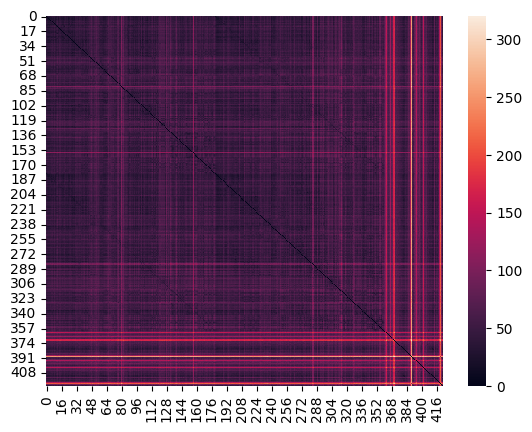

In [17]:
dtw_cl = calc_dtw(closed[0])
heatmap(dtw_cl)

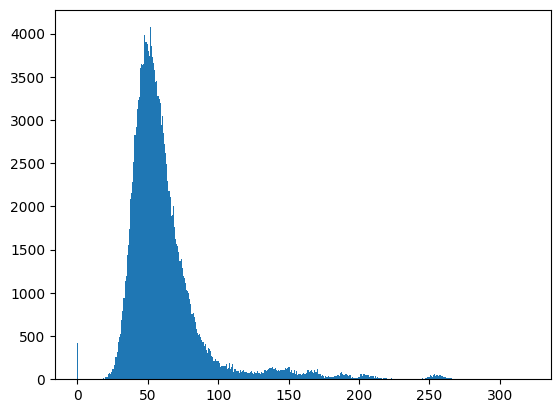

In [30]:
plt.hist(dtw_cl.flatten(), bins='auto');

<Axes: >

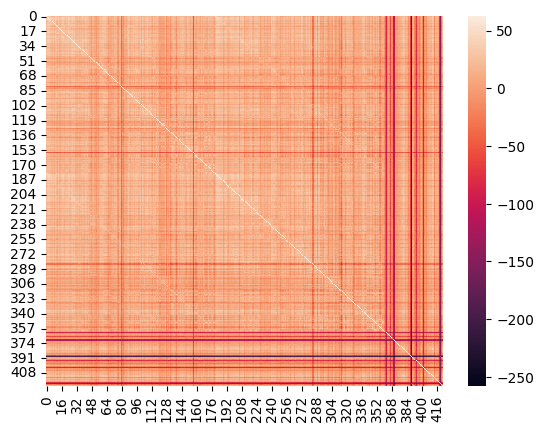

In [44]:
sim_dtw = -dtw_cl - np.mean(-dtw_cl)
heatmap(sim_dtw)

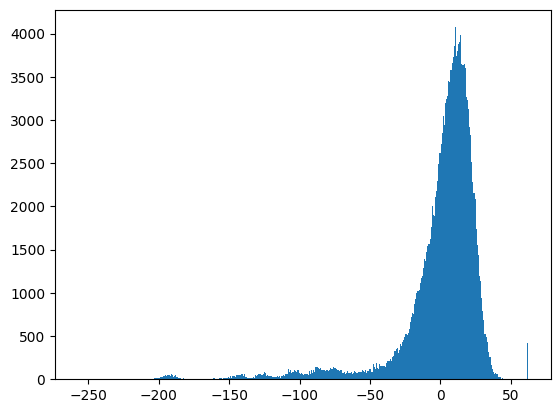

In [45]:
plt.hist(sim_dtw.flatten(), bins='auto');

### FC

In [9]:
def functional_connectivity(ts, measure="correlation"):
    """
    Functional connectivity calculation

    Parameters
    ----------
    ts: list, np.array
        List of np.arrays or np.array of shape (2, :, :) or (3, :, :)
    measure: str
        One of ["covariance", "correlation", "partial correlation", "tangent", "precision"]. By default "correlation"

    Returns
    -------
    list of np.arrays or np.array
    """

    connectivity_measure = ConnectivityMeasure(kind=measure, standardize=False)
    fc = []
    if isinstance(ts[0], list):
        for l in ts:
            calc = connectivity_measure.fit_transform(l)
            for i in calc:
                np.fill_diagonal(i, 1)
            fc.append(calc)

    elif (isinstance(ts, np.ndarray) and len(ts.shape) == 2):
        fc = connectivity_measure.fit_transform([ts])
        for i in fc:
            np.fill_diagonal(i, 1)

        if fc.shape[0] == 1:
            fc = np.squeeze(fc)

    elif isinstance(ts, np.ndarray) and len(ts.shape) == 3:
        fc = connectivity_measure.fit_transform(ts)
        for i in fc:
            np.fill_diagonal(i, 1)

        if fc.shape[0] == 1:
            fc = np.squeeze(fc)

    elif isinstance(ts, list):
        fc = connectivity_measure.fit_transform(ts)
        for i in fc:
            np.fill_diagonal(i, 1)


    return fc

In [10]:
fc_cl = functional_connectivity(closed, 'correlation')
fc_op = functional_connectivity(opened, 'correlation')

<Axes: >

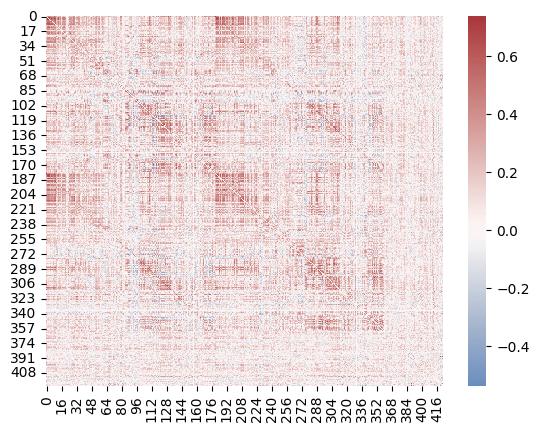

In [22]:
heatmap(fc_cl[6], center=0, cmap='vlag')

In [18]:
pc_cl = functional_connectivity(closed, 'partial correlation')
pc_op = functional_connectivity(opened, 'partial correlation')

<Axes: >

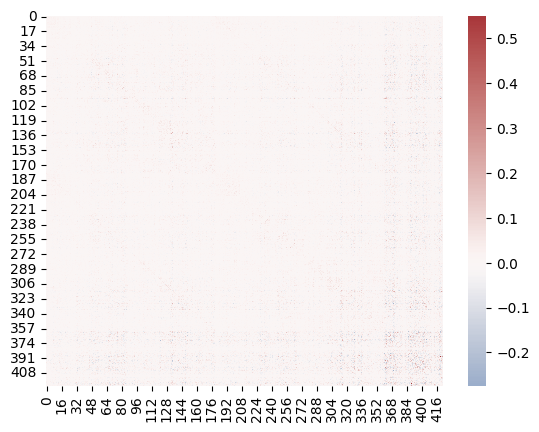

In [20]:
heatmap(pc_cl[6], center=0, cmap='vlag')

### LASSO

In [6]:
import os
import numpy as np
from scipy import stats
from scipy import linalg
from gglasso.problem import glasso_problem # (We began using the GGLasso package (https://gglasso.readthedocs.io/en/latest/) after sklearn's GraphicalLasso would not converge for all subjects for the tested hyperparameters)
from sklearn.covariance import log_likelihood, empirical_covariance

In [14]:
def graphicalLassoCV(data,L1s=None,kFolds=10,optMethod='loglikelihood',saveFiles=0,outDir=''):
    '''
    Runs graphical lasso to compute the L1-regularized partial correlation matrix of a dataset, 
    using cross-validation to select the optimal L1 hyperparameter. 
    Currently, model performance for each hyperparameter value is scored as: 
    the loglikelihood between the training data precision (regularized inverse covariance) matrix and held-out data empirical (unregularized) covariance matrix; or the R^2 between held-out activity (time series) predicted for each node using the training data connectivity matrix and the actual held-out activity (time series).
    INPUT:
        data : a dataset with dimension [nNodes x nDatapoints]
        L1s : list of L1 (lambda1) hyperparameter values to test (all values must be >0); 
        scales the lasso penalty term; the default L1s may not be suitable for all datasets and are only intended as a starting point
        kFolds : number of cross-validation folds to use during hyperparameter selection (FC model is fit k times, each time using all folds but one)
        optMethod : method for choosing the optimal hyperparameter ('loglikelihood' or 'R2')
        saveFiles : whether to save intermediate and output variables to .npy files (0 = no, 1 = save R^2 and negative loglikelihood results, 2 = save connectivity and precision matrices too
        outDir : if saveFiles>=1, the directory in which to save the files
    OUTPUT:
        parCorr : graphical lasso (L1-regularized partial correlation) connectivity matrix, using optimal L1 value from list of L1s
        cvResults : dictionary with 'bestParam' for the optimal L1 value from input list of L1s ('L1s') and 'loglikelihood' or 'R2' containing scores for every cross validation fold and L1 value
    '''

    if not ((optMethod == 'loglikelihood') or (optMethod == 'R2')):
        raise ValueError(f'optMethod "{optMethod}" does not match available methods. Available options are "loglikelihood" and "R2".')

    if L1s is None:
        # Test log-scaled range of L1s (from 0.316 to 0.001)
        L1s = np.arange(-.5,-3.1,-.1) 
        L1s = 10**L1s
        # We recommend checking the optimal hyperparameters for a few subjects and then narrowing down the range
    else:
        L1s = np.array(L1s)

    # Divide timepoints into folds
    nTRs = data.shape[1]
    kFoldsTRs = np.full((kFolds,nTRs),False)
    k = 0
    for t in range(nTRs):
        kFoldsTRs[k,t] = True
        k += 1
        if k >= kFolds:
            k = 0

    # Define arrays to hold performance metrics
    scores = np.zeros((len(L1s),kFolds))

    # If saving intermediate files
    if saveFiles >= 1:

        # Where to save files
        if outDir == '':
            outDir = os.getcwd()
            print(f'Directory for output files not provided, saving to current directory:\n{outDir}')
        if not os.path.exists(outDir):
            os.mkdir(outDir)

        # Loop through L1s
        for l,L1 in enumerate(L1s):
            outfileCVScores = f'{outDir}/L1-{L1}_{optMethod}.npy'

            # If performance metrics were already saved for this L1, load them and move on
            if os.path.exists(outfileCVScores):
                scores[l,:] = np.load(outfileCVScores)
                continue

            # Loop through folds
            for k in range(kFolds):
                outfileParCorr = f'{outDir}/L1-{L1}_kFolds-{k+1}of{kFolds}_partialCorr.npy'
                outfilePrec = f'{outDir}/L1-{L1}_kFolds-{k+1}of{kFolds}_precison.npy'

                # Check if partial corr and precision matrices were already created for this fold
                if os.path.exists(outfileParCorr) and os.path.exists(outfilePrec):
                    parCorr = np.load(outfileParCorr)
                    prec = np.load(outfilePrec)
                else:
                    # Estimate the regularized partial correlation and precision (intermediate) matrices
                    parCorr,prec = graphicalLasso(data[:,~kFoldsTRs[k]],L1)

                    # Save partial corr and precision matrices if saveFiles = 2
                    if saveFiles == 2:
                        np.save(outfileParCorr,parCorr)
                        np.save(outfilePrec,prec)

                if optMethod == 'loglikelihood':
                    # Calculate negative loglikelihood
                    empCov_test = np.cov(stats.zscore(data[:,kFoldsTRs[k]],axis=1),rowvar=True)
                    scores[l,k] = -log_likelihood(empCov_test,prec)

                elif optMethod == 'R2':
                    # Calculate R^2
                    scores[l,k],r = activityPrediction(stats.zscore(data[:,kFoldsTRs[k]],axis=1),parCorr)

            # Save performance metrics for this L1
            np.save(outfileCVScores,scores[l,:])

    # If not saving intermediate files
    else:
        # Loop through L1s
        for l,L1 in enumerate(L1s):
            # Loop through folds
            for k in range(kFolds):
                # Estimate the regularized partial correlation and precision (intermediate) matrices
                parCorr,prec = graphicalLasso(data[:,~kFoldsTRs[k]],L1)

                if optMethod == 'loglikelihood':
                    # Calculate negative loglikelihood
                    empCov_test = np.cov(stats.zscore(data[:,kFoldsTRs[k]],axis=1),rowvar=True)
                    scores[l,k] = -log_likelihood(empCov_test,prec)

                elif optMethod == 'R2':
                    # Calculate R^2
                    scores[l,k],r = activityPrediction(stats.zscore(data[:,kFoldsTRs[k]],axis=1),parCorr)

    # Find the best param according to each performance metric
    meanScores = np.mean(scores,axis=1)
    if optMethod == 'loglikelihood':
        bestParam = L1s[meanScores==np.amin(meanScores)]
    elif optMethod == 'R2':
        bestParam = L1s[meanScores==np.amax(meanScores)]

    # Estimate the regularized partial correlation using all data and the optimal hyperparameters
    parCorr,prec = graphicalLasso(data,bestParam)

    if saveFiles >= 1:
        np.save(f'{outDir}/bestL1_opt-{optMethod}.npy',bestParam)
        np.save(f'{outDir}/graphLasso_opt-{optMethod}.npy',parCorr)

    cvResults = {'bestParam': bestParam, optMethod: scores, 'L1s': L1s}

    return parCorr,cvResults

In [7]:
def graphicalLasso(data, L1):
    '''
    Calculates the L1-regularized partial correlation matrix of a dataset. 
    Runs GGLasso's graphical lasso function (glasso_problem.solve()) and several other necessary steps.
    INPUT:
        data : a dataset with dimension [nNodes x nDatapoints]
        L1 : L1 (lambda1) hyperparameter value
    OUTPUT:
        glassoParCorr : regularized partial correlation coefficients (i.e., FC matrix)
        prec : precision matrix, where entries are not yet transformed into partial correlations (used to compute loglikelihood)
    '''

    nNodes = data.shape[0]

    # Z-score the data
    data_scaled = stats.zscore(data, axis=1)

    # Estimate the empirical covariance
    empCov = np.cov(data_scaled, rowvar=True)

    # Number of timepoints in data
    nTRs = data.shape[1]

    # Run glasso
    glasso = glasso_problem(empCov, nTRs, reg_params={'lambda1':L1}, latent=False, do_scaling=False)
    glasso.solve(verbose=False)
    prec = np.squeeze(glasso.solution.precision_)

    # Transform precision matrix into regularized partial correlation matrix
    denom = np.atleast_2d(1. / np.sqrt(np.diag(prec)))
    glassoParCorr = -prec * denom * denom.T
    np.fill_diagonal(glassoParCorr, 0)

    return glassoParCorr, prec


In [10]:
closed[0].T.shape

(423, 120)

In [15]:
glassoParCorr, prec = graphicalLassoCV(closed[0].T)

ADMM terminated after 247 iterations with status: optimal.
ADMM terminated after 253 iterations with status: optimal.
ADMM terminated after 259 iterations with status: optimal.
ADMM terminated after 11 iterations with status: optimal.
ADMM terminated after 236 iterations with status: optimal.
ADMM terminated after 248 iterations with status: optimal.
ADMM terminated after 238 iterations with status: optimal.
ADMM terminated after 257 iterations with status: optimal.
ADMM terminated after 254 iterations with status: optimal.
ADMM terminated after 260 iterations with status: optimal.
ADMM terminated after 238 iterations with status: optimal.
ADMM terminated after 169 iterations with status: optimal.
ADMM terminated after 175 iterations with status: optimal.
ADMM terminated after 176 iterations with status: optimal.
ADMM terminated after 160 iterations with status: optimal.
ADMM terminated after 166 iterations with status: optimal.
ADMM terminated after 171 iterations with status: optimal

KeyboardInterrupt: 

<Axes: >

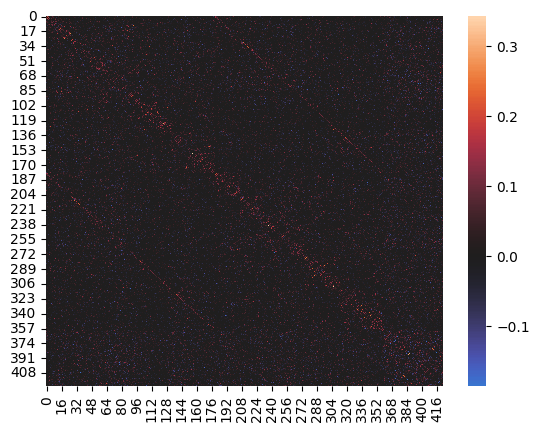

In [13]:
heatmap(glassoParCorr, center=0)

In [ ]:
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# todo                                         
# https://colelab.github.io/ActflowToolbox/HCP_example.html

#Stats on FC matrices
FCdensities=np.zeros(numsubjs)
scount=0
for subj in subjNums:
    numNodes=np.shape(restFC_glassoFC)[0]
    FCdensities[scount]=np.sum(np.abs(restFC_glassoFC[:,:,scount])>0)/(numNodes*(numNodes-1))*100
    scount += 1

print('FC densities (100 X total # of non-zero connections / total possible connections):')
print('Mean:',np.mean(FCdensities),'%')
print('Stdev:',np.std(FCdensities),'%')
print('Range:',np.min(FCdensities),'% to',np.max(FCdensities),'%')

In [15]:
dataset = np.concatenate([fc_cl, fc_op])

In [7]:
from gglasso.problem import glasso_problem

P = glasso_problem(fc_cl, 2, 
                   reg_params={'lambda1': 0.005, 'lambda2': 0.001}, 
                   latent=False, do_scaling=False)

In [16]:
lambda1_range = np.logspace(0, -3, 5)
modelselect_params = {'lambda1_range': lambda1_range}
P.model_selection(modelselect_params = modelselect_params, method = 'eBIC', gamma = 0.1)

KeyboardInterrupt: 

In [9]:
P.solve(verbose=True)

------------ADMM Algorithm for Multiple Graphical Lasso----------------
iter	       r_t	       s_t	   eps_pri	  eps_dual
   0	     5.352	      6533	  0.006357	  0.005701
   1	     2.008	      6531	  0.007663	  0.005701
   2	      2.24	      6532	   0.01028	  0.005701
   3	     2.574	      6531	    0.0155	  0.005701
   4	     2.945	      6531	   0.02595	  0.005701
   5	     3.384	      6531	   0.04685	  0.005701
   6	     3.731	      6531	   0.08865	  0.005701
   7	     4.096	      6531	    0.1723	  0.005701
   8	     4.714	      6531	    0.3395	  0.005701
   9	     5.278	      6531	    0.6739	  0.005701
  10	     5.902	      6531	     1.343	  0.005701
  11	     6.979	      6531	      2.68	  0.005701
  12	     7.993	      6531	     5.356	  0.005701
  13	     9.934	      6531	     10.71	  0.005701
  14	      10.3	      6531	     21.41	  0.005701
  15	     9.483	      6531	     42.81	  0.005701
  16	     9.098	      6531	     85.61	  0.005701
  17	     8.579	      6531	     171.2	  0.0057

/home/tm/projects/OpenCloseProject/nilearn_env/lib/python3.10/site-packages/gglasso/solver/admm_solver.py:248: UserWarning: Omega variable is not symmetric, largest deviation is 10240.0.
  warnings.warn(f"Omega variable is not symmetric, largest deviation is {abs(trp(Omega_t)- Omega_t).max()}.")


<Axes: >

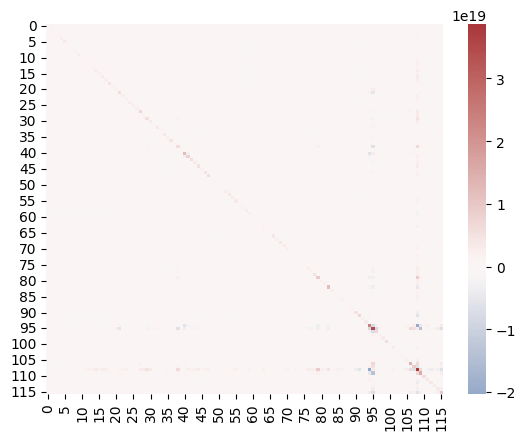

In [10]:
heatmap(P.solution.precision_[10], center=0, cmap='vlag')

## metrics

### BSS

In [13]:
def bss(a1, a2):
    ans = np.zeros(a1.shape[0])
    for i in range(len(a1)):
        ans[i] = np.corrcoef(a1[i], a2[i])[0, 1]
    
    return ans

In [19]:
atlas = 'AAL' # Schaefer200 AAL Brainnetome
strategy = 4

#### china

In [14]:
closed12 = fetch_ts('/data/Projects/OpenCloseChina/outputs_china',
                  sub=closed_ids2, 
                  run=1, atlas_name=atlas, strategy=strategy)
closed13 = fetch_ts('/data/Projects/OpenCloseChina/outputs_china',
                  sub=closed_ids3, 
                  run=1, atlas_name=atlas, strategy=strategy)


closed2 = fetch_ts('/data/Projects/OpenCloseChina/outputs_china',
                  sub=closed_ids2, 
                  run=2, atlas_name=atlas, strategy=strategy)
closed3 = fetch_ts('/data/Projects/OpenCloseChina/outputs_china',
                  sub=closed_ids3, 
                  run=3, atlas_name=atlas, strategy=strategy)



no files available: []
no files available: []
no files available: []
no files available: []


In [34]:
closed13[11].shape

(240, 421)

In [31]:
closed_ids3[11]

3258811

In [15]:
for en, t in enumerate([closed12, closed13, closed2, closed3]):
    for i in range(len(t)):
        if len(t[i]) < 240:
            print(en, i)

3 11


In [11]:
del closed3[11]

In [12]:
del closed13[11]

In [16]:
fc_cl12 = functional_connectivity(closed12, 'correlation')
fc_cl13 = functional_connectivity(closed13, 'correlation')
fc_cl2 = functional_connectivity(closed2, 'correlation')
fc_cl3 = functional_connectivity(closed3, 'correlation')


/home/tm/projects/OpenCloseProject/nilearn_env/lib/python3.10/site-packages/nilearn/connectome/connectivity_matrices.py:509: FutureWarning: The default strategy for standardize is currently 'zscore' which incorrectly uses population std to calculate sample zscores. The new strategy 'zscore_sample' corrects this behavior by using the sample std. In release 0.13, the default strategy will be replaced by the new strategy and the 'zscore' option will be removed. Please use 'zscore_sample' instead.
  covariances_std = [
/home/tm/projects/OpenCloseProject/nilearn_env/lib/python3.10/site-packages/nilearn/connectome/connectivity_matrices.py:509: FutureWarning: The default strategy for standardize is currently 'zscore' which incorrectly uses population std to calculate sample zscores. The new strategy 'zscore_sample' corrects this behavior by using the sample std. In release 0.13, the default strategy will be replaced by the new strategy and the 'zscore' option will be removed. Please use 'zsco

In [17]:
from nilearn.connectome import sym_matrix_to_vec

vec_cl12 = sym_matrix_to_vec(fc_cl12, True)
vec_cl13 = sym_matrix_to_vec(fc_cl13, True)
vec_cl2 = sym_matrix_to_vec(fc_cl2, True)
vec_cl3 = sym_matrix_to_vec(fc_cl3, True)

In [18]:
vec_cl12.shape, vec_cl2.shape

((25, 88410), (25, 88410))

In [51]:
vec_cl3.shape, vec_cl13.shape

((23, 88410), (23, 88410))

In [54]:
ses2 = bss(vec_cl12, vec_cl2)

In [55]:
ses3 = bss(vec_cl13, vec_cl3)

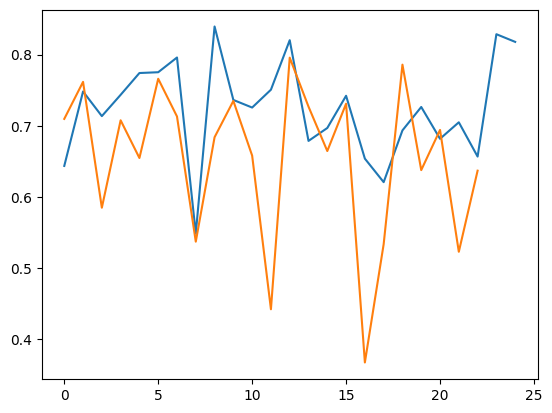

In [56]:
plt.plot(ses2)
plt.plot(ses3)

In [57]:
np.mean(ses2), np.mean(ses3)

(0.7247929414779241, 0.6545172673465423)

#### trt

In [39]:
trt1 = fetch_ts('/home/tm/projects/OpenCloseProject/notebooks/TRT_outputs',
               #sub=,
               run=1, atlas_name=atlas, strategy=strategy)
trt2 = fetch_ts('/home/tm/projects/OpenCloseProject/notebooks/TRT_outputs',
               #sub=,
               run=2, atlas_name=atlas, strategy=strategy)
trt3 = fetch_ts('/home/tm/projects/OpenCloseProject/notebooks/TRT_outputs',
               #sub=,
               run=3, atlas_name=atlas, strategy=strategy)

no files available: []
no files available: []
no files available: []


In [41]:
fc_trt1 = functional_connectivity(trt1, 'correlation')
fc_trt2 = functional_connectivity(trt2, 'correlation')
fc_trt3 = functional_connectivity(trt3, 'correlation')

vec_trt1 = sym_matrix_to_vec(fc_trt1, True)
vec_trt2 = sym_matrix_to_vec(fc_trt2, True)
vec_trt3 = sym_matrix_to_vec(fc_trt3, True)

In [93]:
ses_12 = bss(vec_trt1, vec_trt2)
ses_13 = bss(vec_trt1, vec_trt3)
ses_23 = bss(vec_trt3, vec_trt2)

NameError: name 'bss' is not defined

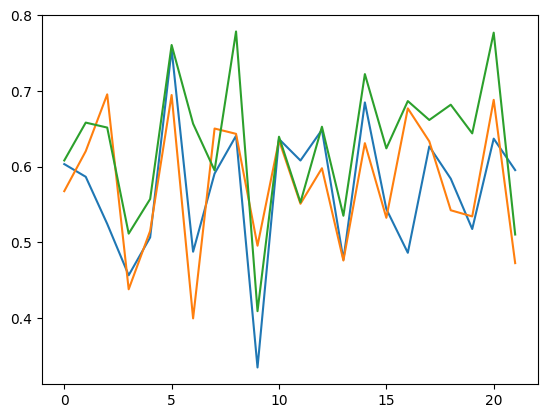

In [61]:
plt.plot(ses_12)
plt.plot(ses_13)
plt.plot(ses_23)

In [62]:
np.mean(ses_12), np.mean(ses_13), np.mean(ses_23)

(0.5695205910591747, 0.5767247047117325, 0.6305748706923276)

### mask

1 для теор и для каждого для натсоящих

In [61]:
vec_cl[0][vec_cl[0] > 0.2].shape

(6909,)

In [69]:
vec_cl[0].shape

(89676,)

In [68]:
sum(np.sum(vec_cl > 0.2, axis=0) == 0)

7450

### icc

repeat reliability

In [11]:
vec_o = sym_matrix_to_vec(fc_op)
vec_cl = sym_matrix_to_vec(fc_cl)

In [12]:
all_mean = np.mean(
    np.concatenate([vec_o, vec_cl]), axis=0
)

In [52]:
all_mean = np.mean(
    np.concatenate([vec_cl12, vec_cl13, vec_cl2, vec_cl3]), axis=0
)

In [ ]:
def mask_vecs(vec, thr):
    pass


сделать класс

In [23]:
from typing import List
from numpy.typing import NDArray

In [39]:
class Metrics:
    def __init__(self, data: List[NDArray], mask_file=None):
        """
        Class to calculate ICC and BSS.

        Parameters
        ----------
        data: list
            list of data for every session to compute metrics
            one session - np.array, vector of functional connectivity
            Note! for BSS calculation only two sessions should be passed
        mask_file: None or np.array, optional
            mask to be used to exclude zero elements (for simulations)

        """
        self.n_ses = len(data)
        self.n_sub = len(data[0])

        self.thrsh = 0.2

        if mask_file is None:
            mask = [d > self.thrsh for d in data]
            self.data = [data[i][mask[i]] for i in range(self.n_ses)]
        else:
            self.mask = [np.array([mask_file for _ in range(self.n_sub)]) for _ in range(self.n_ses)]
            self.data = [data[i][mask[i]] for i in range(self.n_ses)]


    @property
    def _avg_vec(self):
        return np.mean(
            np.concatenate(self.data), axis=0)
    

    def _bms(self) -> float:
        """
        Calculates the sum of squared between-subj variance,
        the average subject value subtracted from overall avg of values

        """
        # group vecs by subject
        sub_vec = [[self.data[ses][sub] for ses in range(self.n_ses)] for sub in range(self.n_sub)]
        
        return np.sum([(self._avg_vec - 
                        np.mean(sub_vec[sub], axis=0)) **2 for sub in range(self.n_sub)]) * self.n_ses


    def _wms(self) -> float:
        """
        calculates the sum of squared Intra-subj variance,
        the average session value subtracted from overall avg of values

        """
        return np.sum([(self._avg_vec - 
                        np.mean(self.data[ses], axis=0)) **2 for ses in range(self.n_ses)]) * self.n_sub


    def icc(self) -> float:
        """
        icc metric

        """
        return ((self._bms() - self._wms()) / 
                (self._bms() + (self.n_ses - 1) * self._wms()))
    

    def bss(self, a1: NDArray = None, a2: NDArray = None) -> float:
        ans = np.zeros(self.n_sub)
        for i in range(self.n_sub):
            ans[i] = np.corrcoef(a1[i], a2[i])[0, 1]
        return np.mean(ans)
    

In [40]:
metric = Metrics([vec_cl13, vec_cl3])
print(metric.icc())
#metric.bss(*metric.data)

0.9985876657643592


In [ ]:
def bms(all_mean, sub, n_ses=2):
    """
    calculates the sum of squared between-subj variance,
    the average subject value subtracted from overall avg of values

    """
    # group vecs by subject
    sub = [[sub[t][i] for t in range(n_ses)] for i in range(len(sub[0]))]
    
    return np.sum([(all_mean - 
                    np.mean(sub[i], axis=0)) **2 for i in range(len(sub))]) * n_ses



def wms(all_mean, ses):
    """
    calculates the sum of squared Intra-subj variance,
    the average session value subtracted from overall avg of values

    """

    return np.sum([(all_mean - 
                    np.mean(ses[i], axis=0))**2 for i in range(len(ses))]) * len(ses[0])

In [43]:
def bms(all_mean, sub, n_ses=2):
    """
    calculates the sum of squared between-subj variance,
    the average subject value subtracted from overall avg of values

    parameters
    ----------
    all_mean: np.array
        overall average vec
    sub: list
        list of arrays with data by sessions
        shape of arrays: [n_sub, fc flattened]
    n_ses: int
        number of sessions
    returns
    -------
    bms metric, float

    """
    # group vecs by subject
    sub = [[sub[t][i] for t in range(n_ses)] for i in range(len(sub[0]))]
    
    return np.sum([(all_mean - 
                    np.mean(sub[i], axis=0)) **2 for i in range(len(sub))]) * n_ses






def wms(all_mean, ses):
    """
    calculates the sum of squared Intra-subj variance,
    the average session value subtracted from overall avg of values
    
    parameters
    ----------
    all_mean: np.array
        overall average vec
    ses: list
        list of arrays with data by sessions
        shape of arrays: [n_sub, fc flattened]

    """

    return np.sum([(all_mean - 
                    np.mean(ses[i], axis=0))**2 for i in range(len(ses))]) * len(ses[0])

In [53]:
bms(all_mean, [vec_cl13, vec_cl3])

36653.346367190294

In [54]:
wms(all_mean, [vec_cl12, vec_cl2])

1437.4542081857137

In [45]:
def icc(all_mean, s, n_ses) -> float:
    """
    icc metric

    parameters
    ----------
    all_mean: np.array
        overall average vec
    s: list
        list of arrays with data by sessions
        shape of arrays: [n_sub, fc flattened]
    n_ses: int
        number of sessions
    returns
    -------
    icc metric, float
    """
    return (bms(all_mean, s, n_ses) - wms(all_mean, s)) / (bms(all_mean, s, n_ses) + (n_ses - 1) * wms(all_mean, s))

In [15]:
icc(all_mean, [vec_o, vec_cl], 2)

0.9678443612343172

In [55]:
icc(all_mean, [vec_cl12, vec_cl2], 2)

0.913840802523959

In [56]:
icc(all_mean, [vec_cl13, vec_cl3], 2)

0.8969304052442951

In [44]:
all_mean = np.mean(
    np.concatenate([vec_trt1, vec_trt2, vec_trt3]), axis=0
)
icc(all_mean, [vec_trt1, vec_trt2, vec_trt3], 3)

0.8590523319009121

### qc-fc

In [ ]:
def mean_fd(sub, run, data):
    return np.mean(data.get_confounds_one_subject(sub)[run-1]['framewise_displacement'][1:])

def qc_fc(fc, run, mean_fd_vec):
    qc_mat = np.zeros((fc.shape[1], fc.shape[2]))
    for i in range(fc.shape[1]):
        for t in range(fc.shape[2]):
            qc_mat[i, t] = np.corrcoef(fc[:, i, t], mean_fd_vec[run-1])[0, 1]
    return qc_mat
